In [1]:
%matplotlib inline
import random
from math import floor
import numpy as np
import numpy.random as nr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os, glob, math,time
from scipy import misc

import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, utils
from PIL import Image


from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm 
from sklearn.preprocessing import MultiLabelBinarizer



# Choose dataset 

In [2]:
path2data = "/home/e209440/data/my_distract_driver_data.npy"

# Dataset Class with split data, transformations and onehot code 

In [3]:
class KaggleSafeDriverDataset(Dataset):
    """
    Arguments:
        Path to data (redux or not)
        PIL transforms
        Test data (boolean)
        Validation data (boolean)
        Size of validation data 
        Shuffle indices of validation and Train
        
    """

    def __init__(self, data_path, use_only =1.0, transforms=None, is_test=False,is_val=False,val_size=0.2):
    
        tmp_data = np.load(data_path).item()

        self.transform = transforms
        self.mlb = MultiLabelBinarizer()
        
        if is_test:
            
            length = len(tmp_data['X_test'])
            only = int(use_only * length)
            self.X = tmp_data['X_test'][:only]
            
            self.y = None #Gambiarra para poder criar DataSet do Test.
        
        else:
            
            length = len(tmp_data['X_train'])
            indices = list(range(0,length))
            
            nr.seed(4572)
            ind = nr.permutation(indices)
            
            
            length = ind.shape[0]
            only = int(use_only * length)
            
            ind = ind[:only]
            length = ind.shape[0]
            
            split = int(val_size * length)
            
            
            
            if is_val:
                self.X = [tmp_data['X_train'][i] for i in ind[:split]]
                self.y = [tmp_data['y_train'][i] for i in ind[:split]]
                self.y = self.mlb.fit_transform(np.array(self.y).reshape(-1,1))
            else:
                self.X = [tmp_data['X_train'][i] for i in ind[split:]]
                self.y = [tmp_data['y_train'][i] for i in ind[split:]]
                self.y = self.mlb.fit_transform(np.array(self.y).reshape(-1,1))
    
   

    def __getitem__(self, index):
        path = self.X[index]
        label = self.y[index]
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                image = img.convert('RGB')                
        if self.transforms is not None:
            image = self.transforms(image)
        return image, label

    def __len__(self):
        return len(self.X)
    

In [4]:
batch_size = 250
img_width, img_height = 50, 50
use_only = 0.2 # Use only 20% of the full dataset

def my_transforms(img, img_width=img_width, img_height=img_height):
    return img.resize((img_width, img_height))

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}

dsets = {
    'train': KaggleSafeDriverDataset(path2data, transforms=data_transforms['train'],use_only=use_only),
    'valid': KaggleSafeDriverDataset(path2data, transforms=data_transforms['valid'],use_only=use_only, is_val=True, val_size=0.2),
    'test':  KaggleSafeDriverDataset(path2data, transforms=data_transforms['valid'],use_only=use_only, is_test=True),
}

In [5]:
dset_loaders = {
    'train': tc.utils.data.DataLoader(dsets['train'], batch_size=batch_size, shuffle=True, num_workers=4), # 1 for CUDA # pin_memory=True # CUDA only
    'valid': tc.utils.data.DataLoader(dsets['valid'], batch_size=batch_size, shuffle=True,num_workers=4),
    'test':  tc.utils.data.DataLoader(dsets['test'],  batch_size=batch_size, shuffle=False,num_workers=4),
}

In [6]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid', 'test']}
dset_classes = len(dsets['train'].y)
dset_classes, dset_sizes

# Datates has much more samples than datatrain ***It comes from the test.zip****

(3588, {'test': 15945, 'train': 3588, 'valid': 896})

# Plotting some examples

In [7]:
# Stub function 

# We need to adjust it to get images from either the test_loader(DataLoader) or trainset(Dataset)

# There is an example in https://t-adessowiki.fee.unicamp.br/user/e209440/notebooks/ia368z_2s2017/lotufo/ia368z/deliver-pytorch/Cats_and_dogs.ipynb

def plot_classes(labels, X, Y, img_size):
 """    #plt.figure(figsize=(20,10))
    size_subp= len(labels)
    cnt=1
    for i in labels:
        plt.figure()
        ix = random.randint(0, len(np.where(Y==str(i))[0]))
        ind = np.where(Y==int(i[-1]))[0][ix]
        image = X[ind].reshape(3,img_size,img_size).transpose((1,2,0))
        #plt.subplot(5,2, cnt)
        plt.imshow(image, cmap=plt.cm.gray_r)
        plt.axis('off')
        plt.title(labels[i])
        cnt +=1 
 """        

In [8]:
#plot_classes(labels, data['X_train'], data['Y_train'], img_size)

# Data Analysis

In [9]:
def de_para(dataset): 
    labels = {  'c0' : 'safe driving', 
                'c1' : 'texting - right', 
                'c2' : 'talking on the phone - right', 
                'c3' : 'texting - left', 
                'c4' : 'talking on the phone - left', 
                'c5' : 'operating the radio', 
                'c6' : 'drinking', 
                'c7' : 'reaching behind', 
                'c8' : 'hair and makeup', 
                'c9' : 'talking to passenger'}
    y = dataset.mlb.inverse_transform(dataset.y)
    class_number = [item[0] for item in y]
    class_str = []
    for item in class_number:
        class_str.append(labels['c'+str(item)])
            
    return class_str        
    

In [10]:
class_str = de_para(dsets['train'])
class_str

['drinking',
 'talking on the phone - left',
 'operating the radio',
 'drinking',
 'hair and makeup',
 'texting - left',
 'texting - left',
 'texting - left',
 'safe driving',
 'hair and makeup',
 'reaching behind',
 'talking on the phone - right',
 'safe driving',
 'texting - right',
 'operating the radio',
 'talking to passenger',
 'drinking',
 'hair and makeup',
 'drinking',
 'reaching behind',
 'texting - right',
 'talking on the phone - right',
 'talking on the phone - right',
 'reaching behind',
 'drinking',
 'safe driving',
 'drinking',
 'talking to passenger',
 'texting - right',
 'safe driving',
 'drinking',
 'safe driving',
 'texting - left',
 'talking on the phone - left',
 'talking on the phone - right',
 'talking on the phone - right',
 'talking to passenger',
 'talking to passenger',
 'texting - left',
 'operating the radio',
 'drinking',
 'safe driving',
 'talking on the phone - right',
 'talking on the phone - right',
 'talking on the phone - right',
 'drinking',
 'talk

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


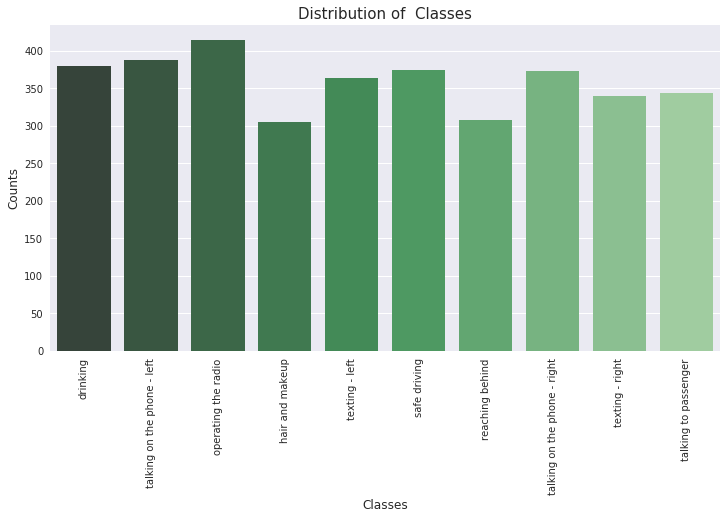

In [11]:
plt.figure(figsize=(12,6))
sns.countplot(x=class_str, palette="Greens_d");
plt.xlabel("Classes", fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=90)
plt.title("Distribution of  Classes", fontsize=15)
plt.show()